In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [11]:
import os
import datetime

import pickle

import tensorflow as tf
import pandas as pd
import numpy as np
from deep_recommender_embeddings.src.ares import request_asset_from_ares
from deep_recommender_embeddings.src.elasticsearch_utils import get_es_instance, get_data_from_es, print_item
from deep_recommender_embeddings.src.image_embeddings import generate_image_embeddings
from deep_recommender_embeddings.src.models import ItemSimilarityModel
from deep_recommender_embeddings.src.plotting import plot_metric
from deep_recommender_embeddings.src.tf_utils import get_tf_lookup_table_for_property, get_tf_lookup_for_dict
from deep_recommender_embeddings.src.inference import get_dict_of_embeddings, build_annoy_index
from deep_recommender_embeddings.src.io import export_embeddings_to_file

%matplotlib inline

from annoy import AnnoyIndex

from deep_recommender_embeddings.src.preprocessing import load_data, clean_data, filter_logs, get_pairs, \
    get_item_pairs_from_journeys, generate_model_recs

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
#%reload_ext autoreload

#reload(deep_recommender_embeddings.src.tf_utils)

In [5]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context


## Load content data from ES

In [6]:
_es_index = 'sfv_02112020'
_es_host = 'localhost'
_es_port = '9200'
es = get_es_instance(es_host=_es_host, es_port=_es_port)

# This is the imaginary date that recommendations will begenerated on
prediction_time = "2020-11-02T00:00:00"

# Business rules usually prevent recs being returned that are older than 90 days so we will only retrieve items
# that were published within this time window
max_age_days = 90

Now let's fetch all the relevant data from elasticsearch. For all items in the publication window we will fetch the id,
all the text, the tags, the category and the image url.

In [7]:
features = ["combinedBodySummaryHeadline","tagsText", "articleCategoryName", "thumbnailUrl"]
hits = get_data_from_es(es, features, 30000, 5000, prediction_time, max_age_days, _es_index)
unique_item_ids = [hit['sort'][0] for hit in hits]
print(f'Grabbed {len(unique_item_ids)} items from elasticsearch')

0
1
2
Grabbed 5060 items from elasticsearch


### Generate tensorflow lookup tables
Tensorflow requires special lookup tables to use in its graph so here we extract the relevant information into these
objects.

In [8]:
body_lookup_table, _ = get_tf_lookup_table_for_property(hits, "combinedBodySummaryHeadline", clean=True)
tags_lookup_table, _ = get_tf_lookup_table_for_property(hits, "tagsText")
category_lookup_table, unique_categories = get_tf_lookup_table_for_property(hits, "articleCategoryName")
thumbnail_lookup_table, _ = get_tf_lookup_table_for_property(hits, "thumbnailUrl")

Tensorflow lookup table created for combinedBodySummaryHeadline with 5060 entries.
Tensorflow lookup table created for tagsText with 3544 entries.
Tensorflow lookup table created for articleCategoryName with 4527 entries.
Tensorflow lookup table created for thumbnailUrl with 5060 entries.


### Generate image embeddings with pretrained model and save


In [12]:
model_link = 'https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4'
embeddings_fpath = '../data/embeddings/image/mobilenet_v2_140_224.pk'
IMAGE_SHAPE = (224,224)
generate_embeddings = False

if generate_embeddings:
    im_embeddings = generate_image_embeddings(model_link, thumbnail_lookup_table, IMAGE_SHAPE, unique_item_ids)
    export_embeddings_to_file(im_embeddings, embeddings_fpath)
else:
    with open(embeddings_fpath, 'rb') as f:
        im_embeddings = pickle.load(f)

In [13]:
im_vec_lookup_table = get_tf_lookup_for_dict(im_embeddings)


Tensorflow lookup table created for vector dim=(1792,) with 5060 entries.


In [14]:
# inp = body_lookup_table.lookup(tf.convert_to_tensor(['/news/uk-england-nottinghamshire-54731548', '/news/election-us-2020-54754797']))
# TEXT_MODEL_LINK = 'https://tfhub.dev/tensorflow/albert_en_large/2'
# #TEXT_MODEL_LINK = 'https://tfhub.dev/google/nnlm-en-dim50/2'
# TEXT_MODEL_LINK = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1'

# text_model_embedding = tf.keras.Sequential([
#     hub.KerasLayer(TEXT_MODEL_LINK,input_shape=[],
#                 dtype=tf.string, trainable=False),
# #    tf.keras.layers.Embedding(input_dim=50, output_dim=embedding_dim, name="text_model_embedding_layer"),
# #    tf.keras.layers.GlobalAveragePooling1D(name="text_model_global_averaging_pooling_layer")
#     ])
# text_model_embedding(inp)


## Load the user data
Load the vocabulary of the of item IDs into a tensorflow dataset.

In [15]:
DATA_PATH = '/Users/mercef02/Projects/datasets_models/sfv_user_user_zoom_20201026_20201102/sfv_user*' #'/Users/mercef02/Projects/datasets/sfv_user_week_compact/*.csv'
logs = load_data(d_path=DATA_PATH, stop_after_n_files=3)
logs = clean_data(logs)

In [16]:
min_date = pd.to_datetime('2020-10-31T00:00:00')
max_date = pd.to_datetime('2020-11-01T11:59:59')
min_mentions = 5
train_logs = filter_logs(logs, min_date, max_date, min_mentions, unique_item_ids)

Original interactions: 7052134
Date filtered interactions: 1772802
Minimum mention filtered interactions  : 1690846
Interactions filtered for items existing in ES : 1241746


### Generate item pairs 
The input for the model is pairs of consecutively consumed items so next we need to convert the journeys into item pairs

In [17]:
train_pairs = get_item_pairs_from_journeys(train_logs)
train_pairs_df = pd.DataFrame(train_pairs)
train_logs_tf = tf.data.Dataset.from_tensor_slices(dict(train_pairs_df))

Total number of item pairs: 242245


Let's visualise what some of these pairs of items look like that will be useful later for a sanity check.

In [18]:
train_pairs_df['shingled'] = train_pairs_df['item_a'] + '_' + train_pairs_df['item_b']
vc = train_pairs_df.shingled.value_counts()
train_pairs_df.head()

,item_a,item_b,shingled
0,/news/world-us-canada-54754415,/news/election-us-2020-54757538,/news/world-us-canada-54754415_/news/election-...
1,/news/world-us-canada-54745441,/news/world-europe-54764386,/news/world-us-canada-54745441_/news/world-eur...
2,/sport/rugby-union/54763014,/sport/rugby-union/54765801,/sport/rugby-union/54763014_/sport/rugby-union...
3,/sport/boxing/54742612,/news/uk-england-nottinghamshire-54731548,/sport/boxing/54742612_/news/uk-england-nottin...
4,/news/uk-54761037,/news/world-europe-54764386,/news/uk-54761037_/news/world-europe-54764386


<AxesSubplot:>

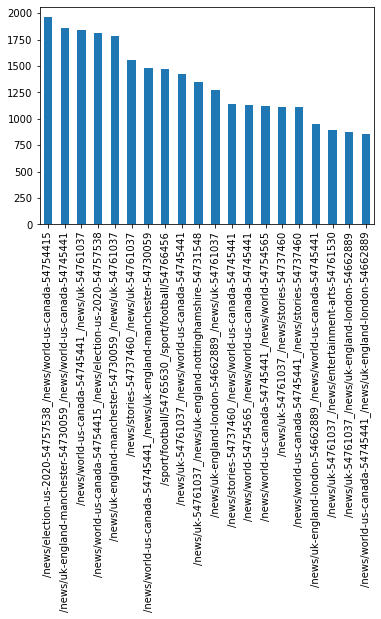

In [19]:
# Here we are visualising the histogram of the item pairs ordered by their frequency.
vc.head(20).plot(kind='bar')

### Holdout data

In [20]:

min_date = pd.to_datetime('2020-11-01T12:00:00')
max_date = pd.to_datetime('2020-11-02T00:00:00')
min_mentions = 5
holdout_logs = filter_logs(logs, min_date, max_date, min_mentions, unique_item_ids)
holdout_pairs = get_item_pairs_from_journeys(holdout_logs)
print(f"Total number of holdout item pairs: {len(holdout_pairs)}")
holdout_logs_tf = tf.data.Dataset.from_tensor_slices(dict(pd.DataFrame(holdout_pairs)))

Original interactions: 7052134
Date filtered interactions: 746980
Minimum mention filtered interactions  : 698555
Interactions filtered for items existing in ES : 505485
Total number of item pairs: 70631
Total number of holdout item pairs: 70631


## Train/Test Split

In [21]:
tf.random.set_seed(42)
training_shuffled = train_logs_tf.shuffle(buffer_size=100_000, seed=42, reshuffle_each_iteration=False)
train_pc = 0.9
test_pc = 0.1
sfv_train = training_shuffled.take(np.floor(len(training_shuffled)*train_pc))
sfv_val = training_shuffled.skip(np.floor(len(training_shuffled)*train_pc))
print(f'Number of train pairs: {len(sfv_train)}')
print(f'Number of test pairs: {len(sfv_val)}')


Number of train pairs: 218020
Number of test pairs: 24225


## Training

In [ ]:
model_link = 'https://tfhub.dev/google/nnlm-en-dim50/2'
model = {"format": "text", "link": model_link}
num_epochs = 10
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_val.batch(128).cache()
model_one_layer = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['item_id'],
                                      feature_dims=[64],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      image_embedding_lookup_table=im_vec_lookup_table,
                                      layer_sizes=[],
                                      pretrained_text_model=model_link)
model_one_layer.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

one_layer_history = model_one_layer.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)


print(f'Train accuracy: {one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')
plot_metric(one_layer_history, 'factorized_top_k/top_100_categorical_accuracy')
print("Hold out metrics:")
metrics = model_one_layer.evaluate(holdout_logs_tf.batch(128).cache())
print(f'Holdout accuracy: {metrics[4]}')
metrics


Epoch 1/10
1704/1704 [==============================] - 175s 100ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0671 - factorized_top_k/top_10_categorical_accuracy: 0.0969 - factorized_top_k/top_50_categorical_accuracy: 0.1658 - factorized_top_k/top_100_categorical_accuracy: 0.2070 - loss: 9.0311 - regularization_loss: 0.0000e+00 - total_loss: 9.0311 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 0.0768 - val_factorized_top_k/top_10_categorical_accuracy: 0.1145 - val_factorized_top_k/top_50_categorical_accuracy: 0.1781 - val_factorized_top_k/top_100_categorical_accuracy: 0.2376 - val_loss: 6.9544 - val_regularization_loss: 0.0000e+00 - val_total_loss: 6.9544
Epoch 2/10
 149/1704 [=>............................] - ETA: 1:40 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0816 - factorized_top_k/top

Epoch 1/4
1704/1704 [==============================] - 135s 79ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0894 - factorized_top_k/top_10_categorical_accuracy: 0.1382 - factorized_top_k/top_50_categorical_accuracy: 0.2286 - factorized_top_k/top_100_categorical_accuracy: 0.2742 - loss: 8.8587 - regularization_loss: 0.0000e+00 - total_loss: 8.8587 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 0.1185 - val_factorized_top_k/top_10_categorical_accuracy: 0.1727 - val_factorized_top_k/top_50_categorical_accuracy: 0.2697 - val_factorized_top_k/top_100_categorical_accuracy: 0.3146 - val_loss: 6.6314 - val_regularization_loss: 0.0000e+00 - val_total_loss: 6.6314
Epoch 2/4
1704/1704 [==============================] - 130s 76ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.1069 - factorized_top_k/t

[0.0,
 0.10326910018920898,
 0.15684331953525543,
 0.27480852603912354,
 0.3037901222705841,
 7.579155921936035,
 0,
 7.579155921936035]

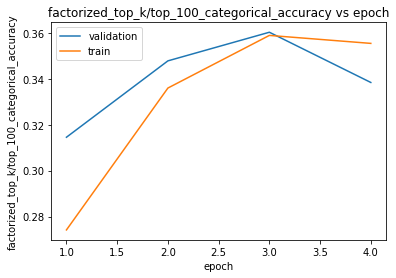

In [169]:
model_link = 'https://tfhub.dev/google/nnlm-en-dim50/2'
model = {"format": "text", "link": model_link}
num_epochs = 4
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_val.batch(128).cache()
model_one_layer = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['item_id' ],
                                      feature_dims=[100],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      image_embedding_lookup_table=im_vec_lookup_table,
                                      layer_sizes=[],
                                      pretrained_text_model=model_link)
model_one_layer.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

one_layer_history = model_one_layer.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)


print(f'Train accuracy: {one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')
plot_metric(one_layer_history, 'factorized_top_k/top_100_categorical_accuracy')
print("Hold out metrics:")
metrics = model_one_layer.evaluate(holdout_logs_tf.batch(128).cache())
print(f'Holdout accuracy: {metrics[4]}')
metrics


In [170]:
save_embeddings_fpath = '../data/embeddings/trained/item_id_100.pkl'
item_embeddings = get_dict_of_embeddings(model_one_layer, unique_item_ids, save_fpath=save_embeddings_fpath)
annoy_index, id_to_uri, uri_to_id = build_annoy_index(item_embeddings)

In [171]:
query_uri, groundtruth_uri = vc.index[4].split('_')
print(f'query_uri = {query_uri}')
print(f'groundtruth_uri = {groundtruth_uri}')

rec_uris = generate_model_recs(query_uri, annoy_index, uri_to_id, id_to_uri, item_embeddings, es, _es_index, 20)
print(f'LITMUS TEST: {groundtruth_uri in rec_uris}')
print('-------------------')
print('-------------------')

for rec in rec_uris:
    print_item(rec, es, _es_index)
    print('-------------------')

query_uri = /news/uk-england-manchester-54730059
groundtruth_uri = /news/uk-54761037
Generating recommendations for:
/news/uk-england-manchester-54730059 
 A man who refused to protect himself says his views were changed by a battle with Covid-19.
-------------------
-------------------
LITMUS TEST: False
-------------------
-------------------
/news/uk-england-manchester-54730059 
 A man who refused to protect himself says his views were changed by a battle with Covid-19.
-------------------
/news/uk-england-54708593 
 John Myatt wore a Roman helmet and his best pair of trunks to complete the 73-mile walk.
-------------------
/news/stories-54737460 
 The racism and abuse suffered by thousands of children born to African-American fathers and white German mothers in post-war Germany.
-------------------
/news/uk-england-tyne-54736028 
 A woman turns her garden into a huge Halloween display in memory of her daughter.
-------------------
/news/world-europe-53802226 
 Crowds gathered in th

Epoch 1/10
1704/1704 [==============================] - 552s 323ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0160 - factorized_top_k/top_5_categorical_accuracy: 0.0962 - factorized_top_k/top_10_categorical_accuracy: 0.1391 - factorized_top_k/top_50_categorical_accuracy: 0.2477 - factorized_top_k/top_100_categorical_accuracy: 0.3174 - loss: 4.4145 - regularization_loss: 0.0000e+00 - total_loss: 4.4145 - val_factorized_top_k/top_1_categorical_accuracy: 0.0304 - val_factorized_top_k/top_5_categorical_accuracy: 0.1051 - val_factorized_top_k/top_10_categorical_accuracy: 0.1408 - val_factorized_top_k/top_50_categorical_accuracy: 0.2565 - val_factorized_top_k/top_100_categorical_accuracy: 0.3404 - val_loss: 2.8968 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2.8968
Epoch 2/10
1704/1704 [==============================] - 529s 310ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0215 - factorized_top_k/top_5_categorical_accuracy: 0.1100 - factorized_top_k/top_10_ca

Train accuracy: 0.38351067900657654
Validation accuracy: 0.39318886399269104
Hold out metrics:
552/552 [==============================] - 148s 267ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0191 - factorized_top_k/top_5_categorical_accuracy: 0.0835 - factorized_top_k/top_10_categorical_accuracy: 0.1544 - factorized_top_k/top_50_categorical_accuracy: 0.2980 - factorized_top_k/top_100_categorical_accuracy: 0.3552 - loss: 4.6922 - regularization_loss: 0.0000e+00 - total_loss: 4.6922
Holdout accuracy: 0.3552123010158539


[0.019085103645920753,
 0.08349025249481201,
 0.15443643927574158,
 0.2980419397354126,
 0.3552123010158539,
 4.626432418823242,
 0,
 4.626432418823242]

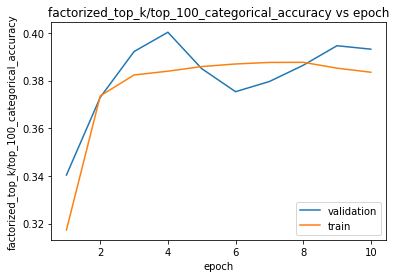

In [172]:
model_link = 'https://tfhub.dev/google/nnlm-en-dim50/2'
model = {"format": "text", "link": model_link}
num_epochs = 10
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_val.batch(128).cache()
model_one_layer = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['image_embedding', 'body'],
                                      feature_dims=[100, 64],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      image_embedding_lookup_table=im_vec_lookup_table,
                                      layer_sizes=[],
                                      pretrained_text_model=model_link)
model_one_layer.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

one_layer_history = model_one_layer.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)


print(f'Train accuracy: {one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')
plot_metric(one_layer_history, 'factorized_top_k/top_100_categorical_accuracy')
print("Hold out metrics:")
metrics = model_one_layer.evaluate(holdout_logs_tf.batch(128).cache())
print(f'Holdout accuracy: {metrics[4]}')
metrics


In [162]:
save_embeddings_fpath = '../data/embeddings/trained/image_100.pkl'
item_embeddings = get_dict_of_embeddings(model_one_layer, unique_item_ids, save_fpath=None)
annoy_index, id_to_uri, uri_to_id = build_annoy_index(item_embeddings)

In [166]:
with open(save_embeddings_fpath, 'wb') as f:
    pickle.dump(item_embeddings, f)

In [167]:
query_uri, groundtruth_uri = vc.index[4].split('_')
print(f'query_uri = {query_uri}')
print(f'groundtruth_uri = {groundtruth_uri}')

rec_uris = generate_model_recs(query_uri, annoy_index, uri_to_id, id_to_uri, item_embeddings, es, _es_index, 20)
print(f'LITMUS TEST: {groundtruth_uri in rec_uris}')
print('-------------------')
print('-------------------')

for rec in rec_uris:
    print_item(rec, es, _es_index)
    print('-------------------')

query_uri = /news/uk-england-manchester-54730059
groundtruth_uri = /news/uk-54761037
Generating recommendations for:
/news/uk-england-manchester-54730059 
 A man who refused to protect himself says his views were changed by a battle with Covid-19.
-------------------
-------------------
LITMUS TEST: True
-------------------
-------------------
/news/uk-england-manchester-54730059 
 A man who refused to protect himself says his views were changed by a battle with Covid-19.
-------------------
/news/uk-england-kent-53727910 
 A 29-year-old man was arrested after a fight broke out at a gathering at Greatstone beach.
-------------------
/news/uk-england-nottinghamshire-54746814 
 The city moved into the top tier of Covid-19 restrictions at midnight after an overall rise in infection rates.
-------------------
/news/world-us-canada-54745441 
 Clive Myrie has visited the Navajo Nation in Arizona where the death rate is the highest in the US.
-------------------
/news/health-53599124 
 The BB

In [ ]:
### Pretrained text model nnlm 50

### Pretrained text model nnlm 128

In [173]:
#model_link = 'https://tfhub.dev/google/nnlm-en-dim50/2'
#model_link = 'https://tfhub.dev/tensorflow/albert_en_large/2'
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'

model = {"format": "text", "link": model_link}
recsys2 = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['text_model'],
                                      feature_dims=[model],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      layer_sizes=[],
                                      pretrained_text_model=model_link)
recsys2.compile(optimizer=tf.keras.optimizers.Adagrad(lr))
recsys2_metrics = recsys2.evaluate(holdout_logs_tf.batch(128).cache())
recsys2_metrics


Using pretrained TEXT model: https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2
552/552 [==============================] - 135s 243ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0014 - factorized_top_k/top_5_categorical_accuracy: 0.0270 - factorized_top_k/top_10_categorical_accuracy: 0.0425 - factorized_top_k/top_50_categorical_accuracy: 0.1208 - factorized_top_k/top_100_categorical_accuracy: 0.1472 - loss: 5.0174 - regularization_loss: 0.0000e+00 - total_loss: 5.0174


[0.0014299670001491904,
 0.027041951194405556,
 0.04254505783319473,
 0.12076850235462189,
 0.14720165729522705,
 5.357172012329102,
 0,
 5.357172012329102]

### Pretrained image model 

In [286]:
recsys2_im = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['image_embedding'],
                                      feature_dims=[None],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[])
recsys2_im.compile(optimizer=tf.keras.optimizers.Adagrad(lr))
recsys2_im_metrics = recsys2_im.evaluate(holdout_logs_tf.batch(128).cache())
recsys2_im_metrics


Using pretrained IMAGE model: https://tfhub.dev/google/imagenet/mobilenet_v2_100_96/feature_vector/4
552/552 [==============================] - 79s 143ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0031 - factorized_top_k/top_10_categorical_accuracy: 0.0120 - factorized_top_k/top_50_categorical_accuracy: 0.0499 - factorized_top_k/top_100_categorical_accuracy: 0.0787 - loss: 13.6808 - regularization_loss: 0.0000e+00 - total_loss: 13.6808


[0.0,
 0.003086463548243046,
 0.01203437615185976,
 0.04990726336836815,
 0.07871897518634796]

In [71]:
lr = 0.01
recsys2_im = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['image_embedding'],
                                      feature_dims=[2048],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_vec_lookup_table,
                                      layer_sizes=[])
recsys2_im.compile(optimizer=tf.keras.optimizers.Adagrad(lr))
recsys2_im_metrics = recsys2_im.evaluate(holdout_logs_tf.batch(128).cache())
recsys2_im_metrics


ValueError: in user code:

    <ipython-input-6-e48051f929fe>:177 call  *
        return self.dense_layers(feature_embedding)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__  **
        self.name)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:168 assert_input_compatibility
        layer_name + ' is incompatible with the layer: '

    ValueError: Input 0 of layer sequential_deep is incompatible with the layer: its rank is undefined, but the layer requires a defined rank.


### Pretrained image model and pretrained text model

In [176]:
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'

text_model = {"format": "text", "link": model_link}

recsys2_im = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['text_model', 'image_embedding'],
                                      feature_dims=[text_model, None],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_vec_lookup_table,
                                      layer_sizes=[])
recsys2_im.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

recsys2_im_metrics = recsys2_im.evaluate(holdout_logs_tf.batch(128).cache())
recsys2_im_metrics

Using pretrained TEXT model: https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2


552/552 [==============================] - 125s 225ms/step - factorized_top_k/top_1_categorical_accuracy: 1.4158e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0072 - factorized_top_k/top_10_categorical_accuracy: 0.0098 - factorized_top_k/top_50_categorical_accuracy: 0.0326 - factorized_top_k/top_100_categorical_accuracy: 0.0523 - loss: 4.8432 - regularization_loss: 0.0000e+00 - total_loss: 4.8432


[1.4158089470583946e-05,
 0.007234783377498388,
 0.009839871898293495,
 0.032634396106004715,
 0.05227166414260864,
 4.630845069885254,
 0,
 4.630845069885254]

### Pretrained text model tuned on siamese network

In [179]:
num_epochs = 3
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_val.batch(128).cache()
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
text_model = {"format": "text", "link": model_link}
model_one_layer = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['text_model'],
                                      feature_dims=[text_model],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_vec_lookup_table,
                                      layer_sizes=[100])
model_one_layer.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

one_layer_history = model_one_layer.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

text_deep_metrics = model_one_layer.evaluate(holdout_logs_tf.batch(128).cache())
text_deep_metrics

Using pretrained TEXT model: https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2


Epoch 1/3


1704/1704 [==============================] - 438s 256ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0028 - factorized_top_k/top_5_categorical_accuracy: 0.0115 - factorized_top_k/top_10_categorical_accuracy: 0.0181 - factorized_top_k/top_50_categorical_accuracy: 0.0505 - factorized_top_k/top_100_categorical_accuracy: 0.0833 - loss: 4.6687 - regularization_loss: 0.0000e+00 - total_loss: 4.6687 - val_factorized_top_k/top_1_categorical_accuracy: 3.3024e-04 - val_factorized_top_k/top_5_categorical_accuracy: 0.0106 - val_factorized_top_k/top_10_categorical_accuracy: 0.0152 - val_factorized_top_k/top_50_categorical_accuracy: 0.0433 - val_factorized_top_k/top_100_categorical_accuracy: 0.0809 - val_loss: 3.1797 - val_regularization_loss: 0.0000e+00 - val_total_loss: 3.1797
Epoch 2/3
1704/1704 [==============================] - 430s 252ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0015 - factorized_top_k/top_5_categorical_accuracy: 0.0083 - factorized_top_k/top_10_categorica

[0.0018263935344293714,
 0.014412934891879559,
 0.020968129858374596,
 0.06230974942445755,
 0.10768643021583557,
 5.5161871910095215,
 0,
 5.5161871910095215]

### Siamese network trained with item body text 

In [182]:
num_epochs = 3
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_val.batch(128).cache()
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
text_model = {"format": "text", "link": model_link}
model_one_layer = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['body'],
                                      feature_dims=[64],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_vec_lookup_table,
                                      layer_sizes=[],
                                      compute_metrics=True)
model_one_layer.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

one_layer_history = model_one_layer.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')
model_one_layer.compute_metrics = True
text_deep_metrics = model_one_layer.evaluate(holdout_logs_tf.batch(128).cache())
text_deep_metrics

Epoch 1/3


1704/1704 [==============================] - 564s 330ms/step - factorized_top_k/top_1_categorical_accuracy: 0.5833 - factorized_top_k/top_5_categorical_accuracy: 0.6263 - factorized_top_k/top_10_categorical_accuracy: 0.6516 - factorized_top_k/top_50_categorical_accuracy: 0.6889 - factorized_top_k/top_100_categorical_accuracy: 0.7079 - loss: 4.8505 - regularization_loss: 0.0000e+00 - total_loss: 4.8505 - val_factorized_top_k/top_1_categorical_accuracy: 2.4768e-04 - val_factorized_top_k/top_5_categorical_accuracy: 4.9536e-04 - val_factorized_top_k/top_10_categorical_accuracy: 4.9536e-04 - val_factorized_top_k/top_50_categorical_accuracy: 0.0059 - val_factorized_top_k/top_100_categorical_accuracy: 0.0059 - val_loss: 3.4965 - val_regularization_loss: 0.0000e+00 - val_total_loss: 3.4965
Epoch 2/3
1704/1704 [==============================] - 730s 428ms/step - factorized_top_k/top_1_categorical_accuracy: 0.5939 - factorized_top_k/top_5_categorical_accuracy: 0.6308 - factorized_top_k/top_10_ca

[0.0,
 1.4158089470583946e-05,
 4.2474268411751837e-05,
 0.0001557389769004658,
 0.00018405515584163368,
 4.634729385375977,
 0,
 4.634729385375977]

### Siamese network trained with item tags text

In [342]:
num_epochs = 3
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_test.batch(128).cache()
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
text_model = {"format": "text", "link": model_link}
tags_one_layer = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['tags'],
                                      feature_dims=[64],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_vec_lookup_table,
                                      layer_sizes=[])
tags_one_layer.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

one_layer_history = tags_one_layer.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

tags_deep_metrics = model_one_layer.evaluate(holdout_logs_tf.batch(128).cache())
tags_deep_metrics

Epoch 1/3


1704/1704 [==============================] - 296s 174ms/step - factorized_top_k/top_1_categorical_accuracy: 0.7071 - factorized_top_k/top_5_categorical_accuracy: 0.7391 - factorized_top_k/top_10_categorical_accuracy: 0.7437 - factorized_top_k/top_50_categorical_accuracy: 0.7478 - factorized_top_k/top_100_categorical_accuracy: 0.7514 - loss: 4.8505 - regularization_loss: 0.0000e+00 - total_loss: 4.8505 - val_factorized_top_k/top_1_categorical_accuracy: 0.1431 - val_factorized_top_k/top_5_categorical_accuracy: 0.1450 - val_factorized_top_k/top_10_categorical_accuracy: 0.1528 - val_factorized_top_k/top_50_categorical_accuracy: 0.1528 - val_factorized_top_k/top_100_categorical_accuracy: 0.1528 - val_loss: 3.9120 - val_regularization_loss: 0.0000e+00 - val_total_loss: 3.9120
Epoch 2/3
1704/1704 [==============================] - 308s 181ms/step - factorized_top_k/top_1_categorical_accuracy: 0.4259 - factorized_top_k/top_5_categorical_accuracy: 0.4719 - factorized_top_k/top_10_categorical_ac

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [344]:
tags_deep_metrics = tags_one_layer.evaluate(holdout_logs_tf.batch(128).cache())

552/552 [==============================] - 89s 161ms/step - factorized_top_k/top_1_categorical_accuracy: 0.9632 - factorized_top_k/top_5_categorical_accuracy: 0.9808 - factorized_top_k/top_10_categorical_accuracy: 0.9857 - factorized_top_k/top_50_categorical_accuracy: 0.9872 - factorized_top_k/top_100_categorical_accuracy: 0.9876 - loss: 4.8512 - regularization_loss: 0.0000e+00 - total_loss: 4.8512


### Siamese network trained with item tags text and body

In [345]:
num_epochs = 3
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_val.batch(128).cache()
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
text_model = {"format": "text", "link": model_link}
tags_text_siamese = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['tags', 'body'],
                                      feature_dims=[64, 64],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[])
tags_text_siamese.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

tags_text_history = tags_text_siamese.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {tags_text_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {tags_text_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

tags_text_metrics = tags_text_siamese.evaluate(holdout_logs_tf.batch(128).cache())
tags_text_metrics

Epoch 1/3


1704/1704 [==============================] - 723s 424ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0140 - factorized_top_k/top_5_categorical_accuracy: 0.0587 - factorized_top_k/top_10_categorical_accuracy: 0.0695 - factorized_top_k/top_50_categorical_accuracy: 0.0869 - factorized_top_k/top_100_categorical_accuracy: 0.0950 - loss: 4.8505 - regularization_loss: 0.0000e+00 - total_loss: 4.8505 - val_factorized_top_k/top_1_categorical_accuracy: 0.0088 - val_factorized_top_k/top_5_categorical_accuracy: 0.3333 - val_factorized_top_k/top_10_categorical_accuracy: 0.4036 - val_factorized_top_k/top_50_categorical_accuracy: 0.6738 - val_factorized_top_k/top_100_categorical_accuracy: 0.9617 - val_loss: 3.9120 - val_regularization_loss: 0.0000e+00 - val_total_loss: 3.9120
Epoch 2/3
1704/1704 [==============================] - 653s 383ms/step - factorized_top_k/top_1_categorical_accuracy: 0.6046 - factorized_top_k/top_5_categorical_accuracy: 0.6613 - factorized_top_k/top_10_categorical_ac

[4.2474268411751837e-05,
 0.0003964265051763505,
 0.0003964265051763505,
 0.0016564964316785336,
 0.002067080931738019]

### Deep Siamese network trained with item tags text and body

In [346]:
num_epochs = 3
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_test.batch(128).cache()
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
text_model = {"format": "text", "link": model_link}
tags_body_deep = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['tags', 'body'],
                                      feature_dims=[64, 64],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[96])
tags_body_deep.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

tags_body_deep_metrics = tags_body_deep.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {tags_body_deep_metrics.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {tags_body_deep_metrics.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

tags_body_deep_metrics = tags_body_deep.evaluate(holdout_logs_tf.batch(128).cache())
tags_body_deep_metrics

Epoch 1/3


1704/1704 [==============================] - 746s 438ms/step - factorized_top_k/top_1_categorical_accuracy: 0.3441 - factorized_top_k/top_5_categorical_accuracy: 0.6136 - factorized_top_k/top_10_categorical_accuracy: 0.6474 - factorized_top_k/top_50_categorical_accuracy: 0.6939 - factorized_top_k/top_100_categorical_accuracy: 0.7140 - loss: 4.8505 - regularization_loss: 0.0000e+00 - total_loss: 4.8505 - val_factorized_top_k/top_1_categorical_accuracy: 0.0950 - val_factorized_top_k/top_5_categorical_accuracy: 0.9800 - val_factorized_top_k/top_10_categorical_accuracy: 0.9807 - val_factorized_top_k/top_50_categorical_accuracy: 0.9846 - val_factorized_top_k/top_100_categorical_accuracy: 0.9849 - val_loss: 3.9120 - val_regularization_loss: 0.0000e+00 - val_total_loss: 3.9120
Epoch 2/3
1704/1704 [==============================] - 690s 405ms/step - factorized_top_k/top_1_categorical_accuracy: 0.2354 - factorized_top_k/top_5_categorical_accuracy: 0.4494 - factorized_top_k/top_10_categorical_ac

[0.00788605585694313,
 0.01687644235789776,
 0.016890600323677063,
 0.01694723218679428,
 0.01694723218679428]

### Deep Siamese network trained with item category and body

In [185]:
num_epochs = 3
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_val.batch(128).cache()
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
text_model = {"format": "text", "link": model_link}
tags_body_deep = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['category', 'body'],
                                      feature_dims=[64, 64],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_vec_lookup_table,
                                      layer_sizes=[96])
tags_body_deep.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

tags_body_deep_metrics = tags_body_deep.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {tags_body_deep_metrics.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {tags_body_deep_metrics.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

tags_body_deep_metrics = tags_body_deep.evaluate(holdout_logs_tf.batch(128).cache())
tags_body_deep_metrics

Epoch 1/3


1704/1704 [==============================] - 133232s 78s/step - factorized_top_k/top_1_categorical_accuracy: 0.1037 - factorized_top_k/top_5_categorical_accuracy: 0.1064 - factorized_top_k/top_10_categorical_accuracy: 0.1065 - factorized_top_k/top_50_categorical_accuracy: 0.1228 - factorized_top_k/top_100_categorical_accuracy: 0.1554 - loss: 8.2435 - regularization_loss: 0.0000e+00 - total_loss: 8.2435 - val_factorized_top_k/top_1_categorical_accuracy: 0.0531 - val_factorized_top_k/top_5_categorical_accuracy: 0.0646 - val_factorized_top_k/top_10_categorical_accuracy: 0.0768 - val_factorized_top_k/top_50_categorical_accuracy: 0.1179 - val_factorized_top_k/top_100_categorical_accuracy: 0.1654 - val_loss: 7.2882 - val_regularization_loss: 0.0000e+00 - val_total_loss: 7.2882
Epoch 2/3
1704/1704 [==============================] - 572s 336ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0995 - factorized_top_k/top_5_categorical_accuracy: 0.0995 - factorized_top_k/top_10_categorical_a

[0.19332870841026306,
 0.19454629719257355,
 0.2012430876493454,
 0.255695104598999,
 0.264218270778656,
 8.858963966369629,
 0,
 8.858963966369629]

###  Siamese network trained with item category and body

In [349]:
num_epochs = 3
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_test.batch(128).cache()
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
text_model = {"format": "text", "link": model_link}
tags_body_deep = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['category', 'body'],
                                      feature_dims=[64, 64],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[])
tags_body_deep.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

tags_body_deep_metrics = tags_body_deep.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {tags_body_deep_metrics.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {tags_body_deep_metrics.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

tags_body_deep_metrics = tags_body_deep.evaluate(holdout_logs_tf.batch(128).cache())
tags_body_deep_metrics

Epoch 1/3


1704/1704 [==============================] - 604s 355ms/step - factorized_top_k/top_1_categorical_accuracy: 0.1008 - factorized_top_k/top_5_categorical_accuracy: 0.1013 - factorized_top_k/top_10_categorical_accuracy: 0.1015 - factorized_top_k/top_50_categorical_accuracy: 0.1130 - factorized_top_k/top_100_categorical_accuracy: 0.1380 - loss: 8.6451 - regularization_loss: 0.0000e+00 - total_loss: 8.6451 - val_factorized_top_k/top_1_categorical_accuracy: 0.2182 - val_factorized_top_k/top_5_categorical_accuracy: 0.2192 - val_factorized_top_k/top_10_categorical_accuracy: 0.2193 - val_factorized_top_k/top_50_categorical_accuracy: 0.2220 - val_factorized_top_k/top_100_categorical_accuracy: 0.2450 - val_loss: 7.4189 - val_regularization_loss: 0.0000e+00 - val_total_loss: 7.4189
Epoch 2/3
1704/1704 [==============================] - 526s 309ms/step - factorized_top_k/top_1_categorical_accuracy: 0.1016 - factorized_top_k/top_5_categorical_accuracy: 0.1020 - factorized_top_k/top_10_categorical_ac

[0.11613880842924118,
 0.11659186333417892,
 0.11659186333417892,
 0.12143392860889435,
 0.1405048817396164]

### Pure CF embeddings

In [347]:
num_epochs = 3
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_test.batch(128).cache()
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
text_model = {"format": "text", "link": model_link}
cf_one_layer = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['item_id'],
                                      feature_dims=[100],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[])
cf_one_layer.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

cf_one_layer_history = cf_one_layer.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

id_metrics = cf_one_layer.evaluate(holdout_logs_tf.batch(128).cache())
id_metrics

Epoch 1/3


1704/1704 [==============================] - 139s 82ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0920 - factorized_top_k/top_10_categorical_accuracy: 0.1408 - factorized_top_k/top_50_categorical_accuracy: 0.2360 - factorized_top_k/top_100_categorical_accuracy: 0.2791 - loss: 8.9186 - regularization_loss: 0.0000e+00 - total_loss: 8.9186 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 0.1223 - val_factorized_top_k/top_10_categorical_accuracy: 0.1803 - val_factorized_top_k/top_50_categorical_accuracy: 0.2479 - val_factorized_top_k/top_100_categorical_accuracy: 0.2944 - val_loss: 6.2466 - val_regularization_loss: 0.0000e+00 - val_total_loss: 6.2466
Epoch 2/3
1704/1704 [==============================] - 140s 82ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.1180 - factorized_top_k/top_10_cate

[0.0,
 0.1478104442358017,
 0.17544704675674438,
 0.23131486773490906,
 0.2577621638774872]

###  CF + body + category embeddings

In [350]:
num_epochs = 3
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_test.batch(128).cache()
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
text_model = {"format": "text", "link": model_link}
cf_one_layer = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['item_id', 'body', 'category'],
                                      feature_dims=[64, 64, 64],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[96])
cf_one_layer.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

cf_one_layer_history = cf_one_layer.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

id_metrics = cf_one_layer.evaluate(holdout_logs_tf.batch(128).cache())
id_metrics

Epoch 1/3


1704/1704 [==============================] - 635s 373ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0179 - factorized_top_k/top_5_categorical_accuracy: 0.1033 - factorized_top_k/top_10_categorical_accuracy: 0.1400 - factorized_top_k/top_50_categorical_accuracy: 0.2147 - factorized_top_k/top_100_categorical_accuracy: 0.2598 - loss: 8.1931 - regularization_loss: 0.0000e+00 - total_loss: 8.1931 - val_factorized_top_k/top_1_categorical_accuracy: 0.0143 - val_factorized_top_k/top_5_categorical_accuracy: 0.0896 - val_factorized_top_k/top_10_categorical_accuracy: 0.1346 - val_factorized_top_k/top_50_categorical_accuracy: 0.1858 - val_factorized_top_k/top_100_categorical_accuracy: 0.2609 - val_loss: 8.7385 - val_regularization_loss: 0.0000e+00 - val_total_loss: 8.7385
Epoch 2/3
1704/1704 [==============================] - 561s 329ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0172 - factorized_top_k/top_5_categorical_accuracy: 0.1251 - factorized_top_k/top_10_categorical_ac

[0.019240843132138252,
 0.0867890864610672,
 0.11547337472438812,
 0.19494272768497467,
 0.25967350602149963]

###  CF + body  embeddings

In [352]:
num_epochs = 3
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_test.batch(128).cache()
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
text_model = {"format": "text", "link": model_link}
cf_one_layer = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['item_id', 'body'],
                                      feature_dims=[100, 64],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[100])
cf_one_layer.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

cf_one_layer_history = cf_one_layer.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

id_metrics = cf_one_layer.evaluate(holdout_logs_tf.batch(128).cache())
id_metrics

Epoch 1/3


1704/1704 [==============================] - 600s 352ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0115 - factorized_top_k/top_5_categorical_accuracy: 0.1137 - factorized_top_k/top_10_categorical_accuracy: 0.1675 - factorized_top_k/top_50_categorical_accuracy: 0.2580 - factorized_top_k/top_100_categorical_accuracy: 0.2865 - loss: 5.2211 - regularization_loss: 0.0000e+00 - total_loss: 5.2211 - val_factorized_top_k/top_1_categorical_accuracy: 0.0120 - val_factorized_top_k/top_5_categorical_accuracy: 0.1999 - val_factorized_top_k/top_10_categorical_accuracy: 0.2934 - val_factorized_top_k/top_50_categorical_accuracy: 0.4277 - val_factorized_top_k/top_100_categorical_accuracy: 0.4447 - val_loss: 4.9520 - val_regularization_loss: 0.0000e+00 - val_total_loss: 4.9520
Epoch 2/3
1704/1704 [==============================] - 507s 297ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0243 - factorized_top_k/top_5_categorical_accuracy: 0.2088 - factorized_top_k/top_10_categorical_ac

[0.0201894361525774,
 0.15136413276195526,
 0.23360846936702728,
 0.3986351490020752,
 0.43557360768318176]

In [310]:
num_epochs = 2
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_test.batch(128).cache()
#model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
#text_model = {"format": "text", "link": model_link}
recsys2_im = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['image_embedding'],
                                      feature_dims=[None],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[])

recsys2_im.compile(optimizer=tf.keras.optimizers.Adagrad(lr))
recsys2_im.fit(    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)


print(f'Train accuracy: {one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

recsys2_im_metrics = recsys2_im.evaluate(holdout_logs_tf.batch(128).cache())

recsys2_im_metrics

Epoch 1/2


ValueError: in user code:

    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow_recommenders/models/base.py:76 train_step
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:513 apply_gradients
        grads_and_vars = _filter_grads(grads_and_vars)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:1271 _filter_grads
        ([v.name for _, v in grads_and_vars],))

    ValueError: No gradients provided for any variable: ['counter:0'].


In [352]:
num_epochs = 3
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_test.batch(128).cache()
cf_one_layer = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['item_id', 'body'],
                                      feature_dims=[100, 64],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[100])
cf_one_layer.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

cf_one_layer_history = cf_one_layer.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

id_metrics = cf_one_layer.evaluate(holdout_logs_tf.batch(128).cache())
id_metrics

Epoch 1/3


1704/1704 [==============================] - 600s 352ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0115 - factorized_top_k/top_5_categorical_accuracy: 0.1137 - factorized_top_k/top_10_categorical_accuracy: 0.1675 - factorized_top_k/top_50_categorical_accuracy: 0.2580 - factorized_top_k/top_100_categorical_accuracy: 0.2865 - loss: 5.2211 - regularization_loss: 0.0000e+00 - total_loss: 5.2211 - val_factorized_top_k/top_1_categorical_accuracy: 0.0120 - val_factorized_top_k/top_5_categorical_accuracy: 0.1999 - val_factorized_top_k/top_10_categorical_accuracy: 0.2934 - val_factorized_top_k/top_50_categorical_accuracy: 0.4277 - val_factorized_top_k/top_100_categorical_accuracy: 0.4447 - val_loss: 4.9520 - val_regularization_loss: 0.0000e+00 - val_total_loss: 4.9520
Epoch 2/3
1704/1704 [==============================] - 507s 297ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0243 - factorized_top_k/top_5_categorical_accuracy: 0.2088 - factorized_top_k/top_10_categorical_ac

[0.0201894361525774,
 0.15136413276195526,
 0.23360846936702728,
 0.3986351490020752,
 0.43557360768318176]

In [75]:
num_epochs = 10
lr = 0.01
cached_train = sfv_train.take(256).batch(128).cache()
cached_test = sfv_val.take(256).batch(128).cache()
cf_one_layer = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['item_id', 'body'],
                                      feature_dims=[100, 64],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[])
cf_one_layer.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

cf_one_layer_history = cf_one_layer.fit(
    cached_train,
    validation_data=sfv_val,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

id_metrics = cf_one_layer.evaluate(holdout_logs_tf.batch(128).cache())
id_metrics

Epoch 1/10


2/2 [==============================] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0039 - factorized_top_k/top_100_categorical_accuracy: 0.0039 - loss: 4.8954 - regularization_loss: 0.0000e+00 - total_loss: 4.8954        WARNING:tensorflow:Model was constructed with shape (None,) for input Tensor("item_id_string_lookup_layer_input_6:0", shape=(None,), dtype=string), but it was called on an input with incompatible shape ().


ValueError: in user code:

    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1224 test_function  *
        return step_function(self, iterator)
    <ipython-input-6-e48051f929fe>:104 call  *
        feature_embeddings.append(self.body_embedding(body))
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__  **
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:372 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:386 call
        inputs, training=training, mask=mask)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__
        self.name)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer body_global_averaging_pooling_layer is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 64]


## Are the results sensible?


## Export embeddings into nearest neighbour index

# Let's get the most paired items

In [ ]:
item_embeddings = get_dict_of_embeddings(trained_model, unique_item_ids)
annoy_index, id_to_uri, uri_to_id = build_annoy_index(item_embeddings)

In [ ]:
#query_uri = '/news/technology-53018000'
#query_uri = '/sport/football/53805003'
#query_uri = '/news/business-10665047'
#query_uri = '/news/uk-england-hampshire-53838761'

query_uri, groundtruth_uri = vc.index[1].split('_')
print(f'query_uri = {query_uri}')
print(f'groundtruth_uri = {groundtruth_uri}')

rec_uris = generate_model_recs(query_uri, annoy_index, uri_to_id, id_to_uri, uri_to_embedding, es, _es_index, 20)
print(f'LITMUS TEST: {groundtruth_uri in rec_uris}')
print('-------------------')
print('-------------------')

for rec in rec_uris:
    print_item(rec, es, _es_index)
    print('-------------------')




In [ ]:
# Use brute-force search to set up retrieval using the trained representations.
# index = tfrs.layers.ann.BruteForce(trained_model.item_model)
# index.index(items_tf.batch(100).map(trained_model.item_model), items_tf)
# # Get some recommendations.
# query_uri = '/news/business-10665047'
# query_uri = '129'
# _, titles = index(np.array([query_uri]))
# print(f"Top 3 recommendations for item {query_uri}: {titles[0, :3]}")

In [ ]:
a = request_asset_from_ares()
a

